# Project: No-show Appointments Analysis

## Table of Contents
<ul>
<li><a href="#intro">Introduction</a></li>
<li><a href="#wrangling">Data Wrangling</a></li>
<li><a href="#eda">Exploratory Data Analysis</a></li>
<li><a href="#conclusions">Conclusions</a></li>
</ul>

<a id='intro'></a>
## Introduction

This dataset collects information from 100k medical appointments in Brazil and is focused on the question of whether or not patients show up for their appointment. A number of characteristics about the patient are included in each row. Below are some of the features we have for each record:
- ‘PatientId’ Identification of a patient.
- ‘ScheduledDay’ tells us on what day the patient set up their appointment.
- ‘Neighborhood’ indicates the location of the hospital.
- ‘Scholarship’ indicates whether or not the patient is enrolled in Brasilian welfare program Bolsa Família.
- ‘Neighbourhood’ Where the appointment takes place.
- ‘SMS_received’ 1 or more messages sent to the patient.
- ‘No-show’ it says ‘No’ if the patient showed up to their appointment, and ‘Yes’ if they did not show up.

### Questions

Here are couple of questions we will answer throughout the upcoming investigation:
- Q1: Does the scheduled day being a weekday or a weekend affect whether or not the patient show up?
- Q2: How does the show rate change between morning, afternoon, and late appointments?
- Q3: How does the show rate change between different age groups?
- Q4: How does the show rate change based on gender?
- Q5: Does having a scholarship affect whether or not a patient would show up?
- Q6: Would recieving an SMS affect the patient show-up rate?
- Q7: Which patients have more chance of showing up between those who have Hipertension, Diabetes, Alchoholism and Handcap?
- Q8: Would a patient be more or less likely to show up on his (n)th appointment compared to his 1st appointment? (n > 1)

In [1]:
# import our packages.
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import datetime as dt

sns.set(style='whitegrid')
%matplotlib inline

### Loading Data

In [2]:
# load csv file
df = pd.read_csv('noshowappointments-kagglev2-may-2016.csv')
df.head(1)

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show
0,2.987250e+13,5642903,F,2016-04-29T18:38:08Z,2016-04-29T00:00:00Z,62,JARDIM DA PENHA,0,1,0,0,0,0,No


### Assessing

For us to assess the data, we'll check its dimensions, to know how many records are there and the number of features about each record. We'll check for missing values and duplicates.

In [3]:
# check the dimensions of the dataframe
df.shape

(110527, 14)

In [4]:
# assess the data types and missing values in each column
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110527 entries, 0 to 110526
Data columns (total 14 columns):
PatientId         110527 non-null float64
AppointmentID     110527 non-null int64
Gender            110527 non-null object
ScheduledDay      110527 non-null object
AppointmentDay    110527 non-null object
Age               110527 non-null int64
Neighbourhood     110527 non-null object
Scholarship       110527 non-null int64
Hipertension      110527 non-null int64
Diabetes          110527 non-null int64
Alcoholism        110527 non-null int64
Handcap           110527 non-null int64
SMS_received      110527 non-null int64
No-show           110527 non-null object
dtypes: float64(1), int64(8), object(5)
memory usage: 11.8+ MB


In [5]:
# look out for duplicates
df.duplicated().sum()

0

In [6]:
# look out for null values
(df.isnull().sum()).all()

False

In [7]:
# look up categorical variables in the dataset
df.nunique()

PatientId          62299
AppointmentID     110527
Gender                 2
ScheduledDay      103549
AppointmentDay        27
Age                  104
Neighbourhood         81
Scholarship            2
Hipertension           2
Diabetes               2
Alcoholism             2
Handcap                5
SMS_received           2
No-show                2
dtype: int64

For the Handcap column, as wee can see in the below cell, there are scores from 0 to 5 that sets the level of disability, for our analysis we'll change that later to be only True for 1 to 5 or False for 0.

In [8]:
# check the frequency of each value
df['Handcap'].value_counts()

0    108286
1      2042
2       183
3        13
4         3
Name: Handcap, dtype: int64

In the coming couple of cells, we'll check the percentages for some categorical features we have, just to have an idea how the data is distributed:

In [9]:
# check the percentage of show-ups VS no-shows for the appointments we have in the dataset.
df['No-show'].value_counts(normalize=True)

No     0.798067
Yes    0.201933
Name: No-show, dtype: float64

In [10]:
df['SMS_received'].value_counts(normalize=True)

0    0.678974
1    0.321026
Name: SMS_received, dtype: float64

In [11]:
df['Alcoholism'].value_counts(normalize=True)

0    0.9696
1    0.0304
Name: Alcoholism, dtype: float64

In [12]:
df['Diabetes'].value_counts(normalize=True)

0    0.928135
1    0.071865
Name: Diabetes, dtype: float64

In [13]:
df['Hipertension'].value_counts(normalize=True)

0    0.802754
1    0.197246
Name: Hipertension, dtype: float64

In [14]:
df['Scholarship'].value_counts(normalize=True)

0    0.901734
1    0.098266
Name: Scholarship, dtype: float64

In [15]:
df['Gender'].value_counts(normalize=True)

F    0.649977
M    0.350023
Name: Gender, dtype: float64

<a id='wrangling'></a>
## Data Wrangling

We noticed earlier that the Handcap feature has 5 categories and by inspecting that even further we can see that it's a score from 0 to 4 that represents the level of disability. For our analysis, we only need a true or false, hence we'll replace any value that's not 0 with 1 to represent some level of disability.

In [16]:
df.Handcap.unique()

array([0, 1, 2, 3, 4], dtype=int64)

In [17]:
# replace all values other than 0 with 1
def label_HC(row):
    if row['Handcap'] == 0:
        return 0
    return 1

In [18]:
df['Handcap'] = df.apply(lambda x: label_HC(x), axis = 1)

In [19]:
# confirm changes
df.Handcap.unique()

array([0, 1], dtype=int64)

- For us to answer the first two questions we'll need to create two columns to represent the day of week and the time of day separately from the ScheduledDay column.

In [20]:
# convert our ScheduledDay column dtype to datetime and extract the day name and hour out of it
df['ScheduledDay'] = pd.to_datetime(df['ScheduledDay'])
df['days'] = df['ScheduledDay'].dt.day_name()
df['hour'] = df['ScheduledDay'].dt.hour

In [21]:
# confirm changes
df.head(1)

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show,days,hour
0,2.987250e+13,5642903,F,2016-04-29 18:38:08+00:00,2016-04-29T00:00:00Z,62,JARDIM DA PENHA,0,1,0,0,0,0,No,Friday,18


We need to categorize the days column to be either weekday or weekend.

In [22]:
# categorize the days column to be either weekday or weekend
def label_day(row):
    if row['days'] == 'Monday':
        return 'Weekday'
    if row['days'] == 'Tuesday':
        return 'Weekday'
    if row['days'] == 'Wednesday':
        return 'Weekday'
    if row['days'] == 'Thursday':
        return 'Weekday'
    if row['days'] == 'Friday':
        return 'Weekday'
    if row['days'] == 'Saturday':
        return 'Weekend'
    if row['days'] == 'Sunday':
        return 'Weekend'

In [23]:
df['days'] = df.apply(lambda row: label_day(row), axis=1)

In [24]:
# confirm changes
df.head(1)

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show,days,hour
0,2.987250e+13,5642903,F,2016-04-29 18:38:08+00:00,2016-04-29T00:00:00Z,62,JARDIM DA PENHA,0,1,0,0,0,0,No,Weekday,18


We now need to categorize the times into morning, afternoon, evening and night as per the following categories:
- Morning: 5:00 to 12:00
- Afternoon: 12:00 to 17:00
- Evening: 17:00 to 21:00
- Night: 21:00 to 4:00

In [25]:
# categorize hour column to represent the time of day.
def label_time(row):
    if 5 <= row['hour'] < 12:
        return 'Morning'
    if 12 <= row['hour'] < 17:
        return 'Afternoon'
    if 17 <= row['hour'] < 21:
        return 'Evening'
    if 21 <= row['hour'] <= 4:
        return 'Night'

In [26]:
df['DayTime'] = df.apply(lambda x: label_time(x), axis=1)

In [27]:
# confirm changes
df.head(1)

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show,days,hour,DayTime
0,2.987250e+13,5642903,F,2016-04-29 18:38:08+00:00,2016-04-29T00:00:00Z,62,JARDIM DA PENHA,0,1,0,0,0,0,No,Weekday,18,Evening


In [28]:
# check the distribution of values across different times of day
df.DayTime.value_counts()

Morning      68481
Afternoon    37206
Evening       4837
Name: DayTime, dtype: int64

### Data Cleaning

In [29]:
# to check the distributopn of ages across the dataset
df['Age'].value_counts(bins=15)

(-1.117, 6.733]      13253
(45.4, 53.133]       12482
(29.933, 37.667]     12006
(37.667, 45.4]       11469
(14.467, 22.2]       11419
(53.133, 60.867]     10697
(6.733, 14.467]      10005
(60.867, 68.6]        9633
(22.2, 29.933]        9434
(68.6, 76.333]        5308
(76.333, 84.067]      3386
(84.067, 91.8]        1193
(91.8, 99.533]         231
(99.533, 107.267]        6
(107.267, 115.0]         5
Name: Age, dtype: int64

We notice that there's a negative age value which was probably added by mistake, let's see how many negative values are there in the age column:

In [30]:
(df['Age'] < 0).sum()

1

We can see it's only one row that has that negative value so it won't affect our analysis that much. Let's fill that negative age value with the mean value for the age column and do a quick sanity check:

In [31]:
# replace any negative age value with the mean age
def fill_age(row):
    if row['Age'] < 0:
        return df['Age'].mean()
    return row['Age']

df['Age'] = df.apply(lambda x: fill_age(x), axis=1)

In [32]:
# confirm changes
(df['Age'] < 0).sum()

0

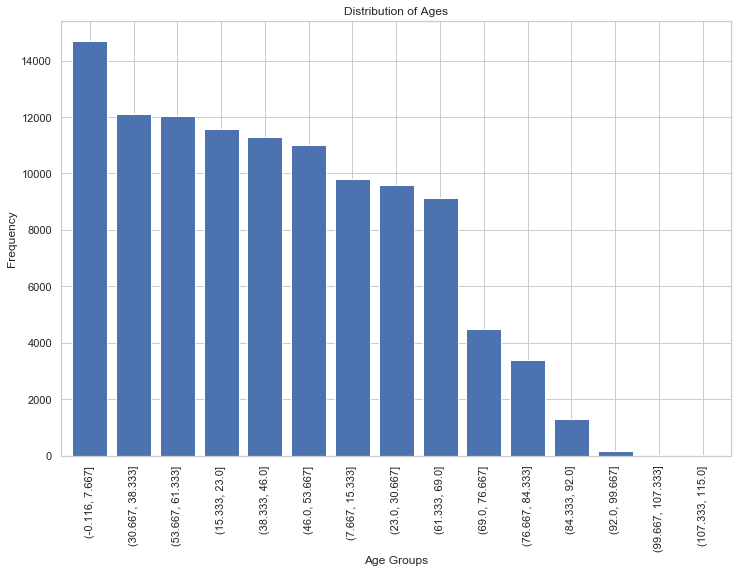

In [33]:
# to visualize the distributopn of ages across the dataset
df['Age'].value_counts(bins=15).plot.bar(width=0.8, figsize=(12,8))
plt.title('Distribution of Ages')
plt.xlabel('Age Groups')
plt.ylabel('Frequency');

<a id='eda'></a>
## Exploratory Data Analysis

#### _It's crtical to mention that our findings in this section are tentative not final as we haven't yet employed any inferential statistics or machine learning techniques to validate them._

### Q1: Does the scheduled day being a weekday or a weekend affect whether or not the patient show up?

In order to compare the show-up rates between the different times of the day, we need compare the percentages not the actual values.

In [34]:
# group by the variables of interest and extract the percentages

day_showrate = df.groupby(['days', 'No-show'])['days'].count().unstack()
day_showrate['Total'] = day_showrate['No'] + day_showrate['Yes']
day_showrate['No_perc'] = day_showrate['No'] / day_showrate['Total']
day_showrate['Yes_perc'] = day_showrate['Yes'] / day_showrate['Total']
day_showrate

No-show,No,Yes,Total,No_perc,Yes_perc
days,,,,,
Weekday,88185,22318,110503,0.798033,0.201967
Weekend,23,1,24,0.958333,0.041667


Based on the above numbers, we find that the **no-show rate is higher for weekdays than it is for weekends.** So, we can say that if a patient has an appointment on a weekend he's more likely to show up than if the appointment was on a weekday. 

Still, we can see that the dataset we have has very few appointments on weekends, which would make our finding not conclusive. 

Below we can see that finding visually:

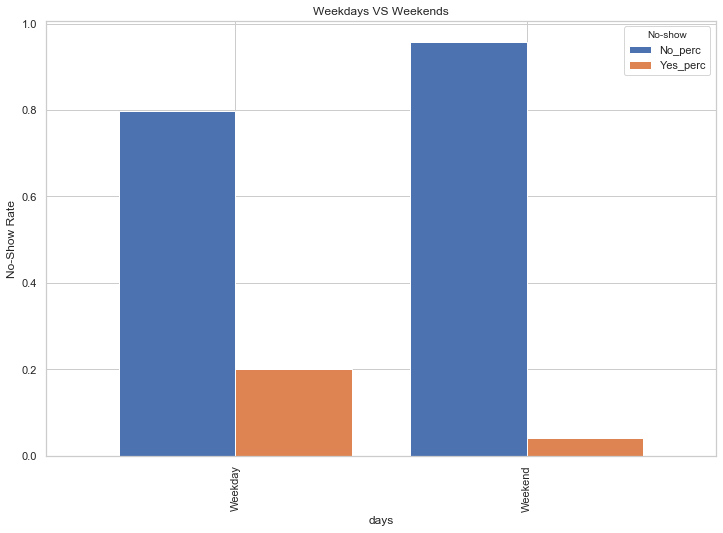

In [35]:
# plot the columns of interest on a bar chart for comparison
day_showrate.drop(['No', 'Yes', 'Total'], axis=1).plot.bar(figsize=(12,8), width=0.8)
plt.title('Weekdays VS Weekends')
plt.ylabel('No-Show Rate');
# Note that the Yes-perc stands for the percentage of patients who didn't show up in each group

### Q2: How does the show rate change between morning, afternoon, and late appointments?

In order to compare the show-up rates between the different times of the day, we need compare the percentages not the actual values.

In [36]:
# group by the variables of interest and extract the percentages

dt_showrate = df.groupby(["DayTime", "No-show"])["DayTime"].count().unstack()
dt_showrate['Total'] = dt_showrate['No'] + dt_showrate['Yes']
dt_showrate['No_perc'] = dt_showrate['No'] / dt_showrate['Total']
dt_showrate['Yes_perc'] = dt_showrate['Yes'] / dt_showrate['Total']

In [37]:
dt_showrate

No-show,No,Yes,Total,No_perc,Yes_perc
DayTime,,,,,
Afternoon,28951,8255,37206,0.778127,0.221873
Evening,3686,1151,4837,0.762043,0.237957
Morning,55569,12912,68481,0.811451,0.188549


Based on the above numbers, we find that the **no-show rate is highest in the evening then the afternoon and lowest in the morning**, even though the bulk of the appointments are made in the morning and the afternoon. 

Hence, we can say that if a patient has an appoinment in the morning or the afternoon, he's more likely to show up than if it was in the evening. 

Below we can see that finding visually:

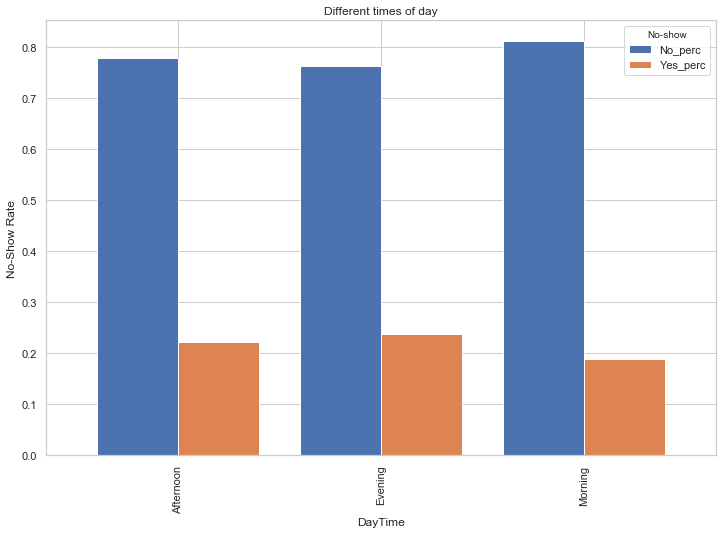

In [38]:
# plot the columns of interest on a bar chart for comparison
dt_showrate.drop(['No', 'Yes', 'Total'], axis=1).plot.bar(figsize=(12,8), width=0.8);
plt.ylabel('No-Show Rate')
plt.title('Different times of day');
# Note that the Yes-perc stands for the percentage of patients who didn't show up in each group

### Q3: How does the show rate change between different age groups?

In order to compare the show-up rates between different age groups, we need to compute the percentages for show-ups and no-shows for each age group.

In [39]:
# group by the variables of interest and extract the percentages

age_showrate = df.groupby(['Age', 'No-show'])['Age'].count().unstack().reset_index()
age_showrate['Total'] = age_showrate['No'] + age_showrate['Yes']
age_showrate['No_perc'] = age_showrate['No'] / age_showrate['Total']
age_showrate['Yes_perc'] = age_showrate['Yes'] / age_showrate['Total']
age_showrate.head()

No-show,Age,No,Yes,Total,No_perc,Yes_perc
0,0.0,2900.0,639.0,3539.0,0.819441,0.180559
1,1.0,1858.0,415.0,2273.0,0.817422,0.182578
2,2.0,1366.0,252.0,1618.0,0.844252,0.155748
3,3.0,1236.0,277.0,1513.0,0.816920,0.183080
4,4.0,1017.0,282.0,1299.0,0.782910,0.217090


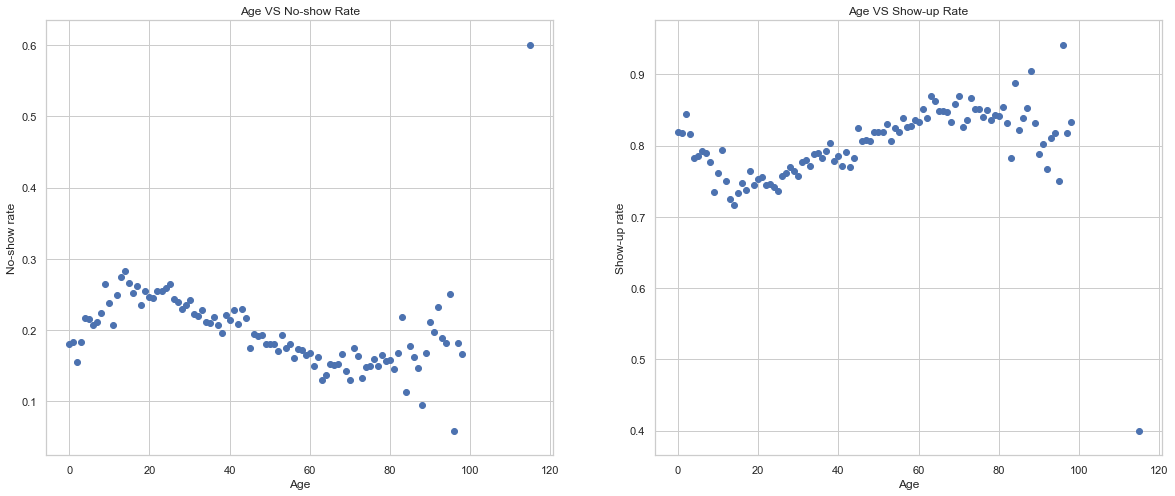

In [40]:
# scatter plot to viualize the different age groups

f, ax = plt.subplots(figsize=(20, 8))
plt.subplot(1, 2, 1)
plt.scatter(x='Age', y='Yes_perc', data=age_showrate)
plt.title("Age VS No-show Rate")
plt.ylabel('No-show rate')
plt.xlabel('Age')
plt.subplot(1, 2, 2)
plt.scatter(x='Age', y='No_perc', data=age_showrate)
plt.title("Age VS Show-up Rate")
plt.ylabel('Show-up rate')
plt.xlabel('Age');

Based on the above figure, 

- left-side: We find that the **no-show rate is highest** for the age group **around 20 (~ 15:~ 30)** and for the age group **older than 90** than it is for other age groups.
- right-side: We find that the **show-up rate is highest** for the **newborn group up to 3 years old** and for the age group **around 70 (~ 60:~ 80)** than it is for other age groups.

Hence, we can say how likely a patient would show up for an appointment based on the age group he belongs to.

### Q4: How does the show rate change based on gender?

In order to compare the show-up rates between different genders, we need compare the percentages not the actual values. Let's compute the percentages for both genders:

In [41]:
# group by the variables of interest and extract the percentages

gender_showrate = df.groupby(['Gender', 'No-show'])['Gender'].count().unstack()
gender_showrate['Total'] = gender_showrate['No'] + gender_showrate['Yes']
gender_showrate['No_perc'] = gender_showrate['No'] / gender_showrate['Total']
gender_showrate['Yes_perc'] = gender_showrate['Yes'] / gender_showrate['Total']
gender_showrate

No-show,No,Yes,Total,No_perc,Yes_perc
Gender,,,,,
F,57246,14594,71840,0.796854,0.203146
M,30962,7725,38687,0.800321,0.199679


Based on the above numbers, we find that the no-show rate is **almost identical** between males and females. Hence, we can say that gender has no statistical effect on whether a patient would show up or not.

Below we can see that finding visually:

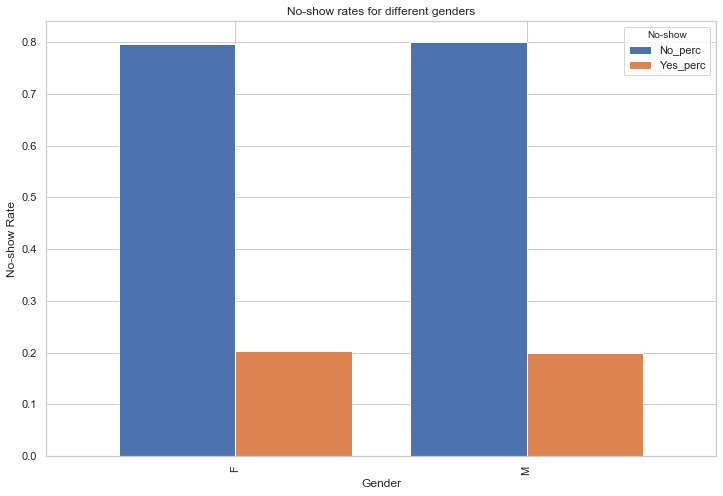

In [42]:
# plot the columns of interest on a bar chart for comparison
gender_showrate.drop(['No', 'Yes', 'Total'], axis=1).plot.bar(figsize=(12,8), width=0.8)
plt.title('No-show rates for different genders')
plt.ylabel('No-show Rate');
# Note that the Yes-perc stands for the percentage of patients who didn't show up in each group

### Q5: Does having a scholarship affect whether or not a patient would show up?

Let's compute the percentages of the patients with a scholarship VS those without a scholarship:

In [43]:
# group by the variables of interest and extract the percentages

schol_showrate = df.groupby(['Scholarship', 'No-show'])['Scholarship'].count().unstack()
schol_showrate['Total'] = schol_showrate['No'] + schol_showrate['Yes']
schol_showrate['No_perc'] = schol_showrate['No'] / schol_showrate['Total']
schol_showrate['Yes_perc'] = schol_showrate['Yes'] / schol_showrate['Total']
schol_showrate.index = ['False', 'True']
schol_showrate

No-show,No,Yes,Total,No_perc,Yes_perc
False,79925,19741,99666,0.801928,0.198072
True,8283,2578,10861,0.762637,0.237363


Based on the above numbers, we can see that a patient who has a scholarship is **slightly more likely not to show up** than a patient who doesn't have a scholarship.

Below we can visualize that finding:

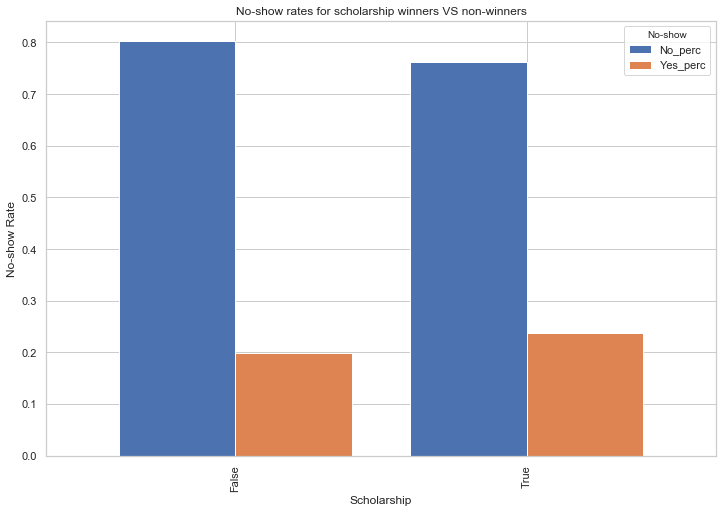

In [44]:
# plot the columns of interest on a bar chart for comparison
schol_showrate.drop(['No', 'Yes', 'Total'], axis=1).plot.bar(figsize=(12,8), width=0.8);
plt.title('No-show rates for scholarship winners VS non-winners')
plt.xlabel('Scholarship')
plt.ylabel('No-show Rate');
# Note that the Yes-perc stands for the percentage of patients who didn't show up in each group

### Q6: Would recieving an SMS affect the patient show-up rate?

Let's first compute how many patients showed up while recieving an SMS and how many didn't:

In [45]:
# group by the variables of interest and extract the percentages

sms_showrate = df.groupby(['SMS_received', 'No-show'])['SMS_received'].count().unstack()
sms_showrate['Total'] = sms_showrate['No'] + sms_showrate['Yes']
sms_showrate['No_perc'] = sms_showrate['No'] / sms_showrate['Total']
sms_showrate['Yes_perc'] = sms_showrate['Yes'] / sms_showrate['Total']
sms_showrate.index = ['False', 'True']
sms_showrate

No-show,No,Yes,Total,No_perc,Yes_perc
False,62510,12535,75045,0.832967,0.167033
True,25698,9784,35482,0.724255,0.275745


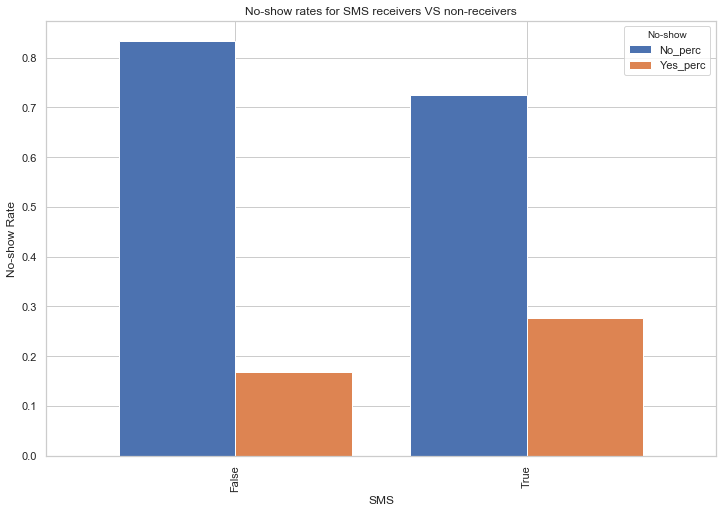

In [46]:
# plot the columns of interest on a bar chart for comparison
sms_showrate.drop(['No', 'Yes', 'Total'], axis=1).plot.bar(figsize=(12,8), width=0.8)
plt.title('No-show rates for SMS receivers VS non-receivers')
plt.xlabel('SMS')
plt.ylabel('No-show Rate');
# Note that the Yes-perc stands for the percentage of patients who didn't show up in each group

Based on the above chart, we can see that the patients **who recieved a message were more likely not to show up** than those who didn't recieve a message, **which might sound counter-intuitive**.

It would take some field-specific knowledge in order to dig deeper into why this is the case as we need to know the basis on which we send a message to a patient because **maybe we're only sending messages to a subset of patients** who have a low show-up rate already due to other factors, in which case the patients' selection would be biased for that feature.

### Q7: Which patients have more chance of showing up between those who have Hipertension, Diabetes, Alcoholism and Handcap?

In [47]:
# In order to be able to calculate the correlation for the other variables with the no-show rate,
# we'll need to exchange the values we have in it with dummy numerical values, zeros and ones in this case.

df['No_show'] = df['No-show']   # we'll use that just to copy the original column.
df['No-show'] = df['No-show'].str.get_dummies()

In [48]:
# we'll calculate the correlation for each of the values with the no-show rate.
hiper_showrate = df['Hipertension'].corr(df['No-show'])
hiper_showrate

0.035701177345014976

In [49]:
diab_showrate = df['Diabetes'].corr(df['No-show'])
diab_showrate

0.01517994382077367

In [50]:
hand_showrate = df['Handcap'].corr(df['No-show'])
hand_showrate

0.007280745542466035

In [51]:
alc_showrate = df['Alcoholism'].corr(df['No-show'])
alc_showrate

0.00019604372362816503

From the above numbers we can say that Hipertension patients are the most likely to show up then the Diabetes then the Handcap patients and the least likely to show up are Alcoholism patients.

Still that finding is **not conclusive** as the numbers of patients in each category are not fairly distributed. For example in the whole dataset we have around 22k Hipertension patients but only 3.3k Alcoholism patients.

We can visualize the numbers here:

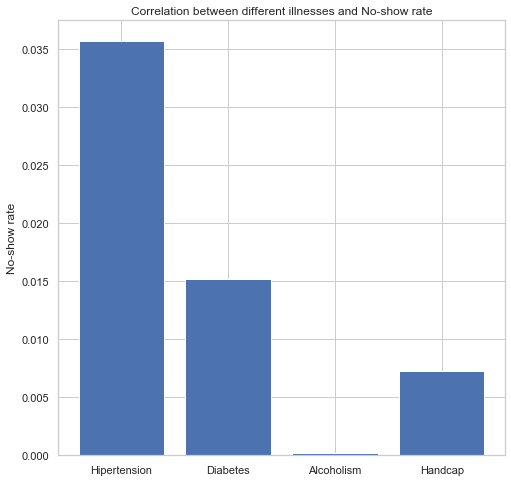

In [52]:
# plot the values of interest on a bar chart for comparison
f, ax = plt.subplots(figsize=(8,8))
plt.bar(x=df.columns[8:12],
        height=[hiper_showrate, diab_showrate, alc_showrate, hand_showrate])
plt.title('Correlation between different illnesses and No-show rate')
plt.ylabel('No-show rate');

### Q8: Would a patient be more or less likely to show up on his (n)th appointment compared to his 1st appointment? (for n > 1)

In order to compare the no-show rate between first-time patients and recurring patients, we'll need to first extract each of those patients from the original dataset. For our analysis' purposes, we'll compare first, second and third-time patients with recurring (n)th-time patinets.

Hence, we'll divide out dataset into 4 dataframes and then merge each of them back with the original dataframe to extract the show-up data for those specific patients only and then compare them all.

In [53]:
# group by the variables of interest and divide the dataframe into 4 dataframes
visits_counts = df.groupby('PatientId')['No-show'].count().reset_index()
first = visits_counts[visits_counts['No-show'] == 1]
second = visits_counts[visits_counts['No-show'] == 2]
third = visits_counts[visits_counts['No-show'] == 3]
nth = visits_counts[visits_counts['No-show'] > 3]

In [54]:
# merge first-time patients with the original dataset to extract their show-up info
first_showrate = df.merge(first, on='PatientId')
first_showrate = first_showrate[['PatientId', 'No-show_x']]
first_showrate.head()

,PatientId,No-show_x
0,8.841186e+12,1
1,7.336882e+14,0
2,5.639473e+13,1
3,7.812456e+13,1
4,7.345362e+14,1


In [55]:
# merge second-time patients with the original dataset to extract their show-up info
second_showrate = df.merge(second, on='PatientId')[['PatientId', 'No-show_x']]
second_showrate.head()

,PatientId,No-show_x
0,2.987250e+13,1
1,2.987250e+13,1
2,5.589978e+14,1
3,5.589978e+14,1
4,4.262962e+12,1


In [56]:
# merge third-time patients with the original dataset to extract their show-up info
third_showrate = df.merge(third, on='PatientId')[['PatientId', 'No-show_x']]
third_showrate.head()

,PatientId,No-show_x
0,2.137540e+14,1
1,2.137540e+14,1
2,2.137540e+14,1
3,1.379437e+11,1
4,1.379437e+11,1


In [57]:
# merge nth-time patients with the original dataset to extract their show-up info
nth_showrate = df.merge(nth, on='PatientId')[['PatientId', 'No-show_x']]
nth_showrate.head()

,PatientId,No-show_x
0,1.215484e+13,0
1,1.215484e+13,1
2,1.215484e+13,1
3,1.215484e+13,0
4,1.215484e+13,1


In [58]:
# concatenate all four dataframes together horizontally
conc_showrate = pd.concat([first_showrate, second_showrate, third_showrate, nth_showrate], 
                          axis=1)
# give the columns somewhat meaningful names
conc_showrate.columns = ['first_id', 'first_sh', 'sec_id', 'sec_sh', 'third_id', 'third_sh', 'nth_id', 'nth_sh']
conc_showrate[['first_sh', 'sec_sh', 'third_sh', 'nth_sh']].head()

,first_sh,sec_sh,third_sh,nth_sh
0,1,1.0,1.0,0.0
1,0,1.0,1.0,1.0
2,1,1.0,1.0,1.0
3,1,1.0,1.0,0.0
4,1,1.0,1.0,1.0


In [59]:
# construct a new dataframe with the frequencies for show-up and no-show rates for each patint type
patient_counts = pd.DataFrame({'first_count': conc_showrate.first_sh.value_counts(),
                               'sec_count': conc_showrate.sec_sh.value_counts(),
                               'third_count': conc_showrate.third_sh.value_counts(),
                               'nth_count': conc_showrate.nth_sh.value_counts(),}).transpose()
patient_counts.columns = ['No', 'Yes']
patient_counts

,No,Yes
first_count,30802,7118
sec_count,22039,5751
third_count,13049,3451
nth_count,22318,5999


In order to compare these values we need percentages, let's compute these percentages here:

In [60]:
# extract the percentages for each type of patients
patient_counts['Total'] = patient_counts['No'] + patient_counts['Yes']
patient_counts['No_perc'] = patient_counts['No'] / patient_counts['Total']
patient_counts['Yes_perc'] = patient_counts['Yes'] / patient_counts['Total']
patient_counts

,No,Yes,Total,No_perc,Yes_perc
first_count,30802,7118,37920,0.812289,0.187711
sec_count,22039,5751,27790,0.793055,0.206945
third_count,13049,3451,16500,0.790848,0.209152
nth_count,22318,5999,28317,0.788148,0.211852


#### Based on the above numbers, we can see that there's a slightly higher chance that a patient would show up on his 1st appointment than on his nth appointment. As the no-show rate for first-appointment patient is the lowest. Let's visualize this:

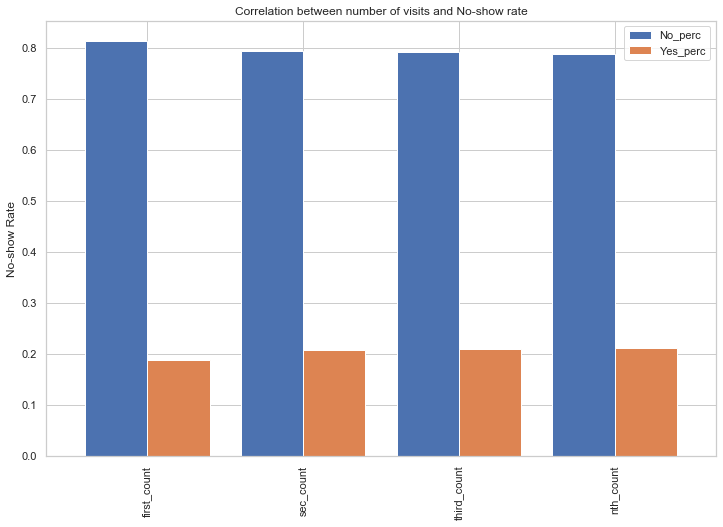

In [61]:
# plot the values of interest on a bar chart for comparison
patient_counts.drop(['No', 'Yes', 'Total'], axis=1).plot.bar(figsize=(12,8), width=0.8)
plt.title('Correlation between number of visits and No-show rate')
plt.ylabel('No-show Rate');
# Note that the Yes-perc stands for the percentage of patients who didn't show up in each group

<a id='conclusions'></a>
## Conclusions

#### In this section, we'll summarize out findings throughout the whole investigation. 

#### _It's crtical to mention that those findings are tentative not final as we haven't yet employed any inferential statistics or machine learning techniques to validate them._

- The no-show rate is higher for **weekdays** than it is for **weekends**.
- The no-show rate is highest in the **evening** then the **afternoon** and lowest in the **morning**.
- The following age groups are more likely to show up than other age groups:
  - Newborn up to 3 years old.
  - Around 70 years old (~ 60:~ 80).
- The following age groups are less likely to show up than other age groups:
  - Around 20 years old (~ 15:~ 30).
  - Older than 90 years old.
- The no-show rate is **almost identical** between males and females.
- The no-show rate is __slightly higher__ for patients who have a scholarship than those who do not.
- The no-show rate is __higher__ for patients who recieve a text message.
- Hipertension patients are the most likely to show up then the Diabetes then the Handcap patients and the least likely to show up are Alcoholism patients.
- The show-up rate is higher for first appointments than it is for recurring appointments.